ML4fungen Final Project Fall 2022 \\
Michelle Campoli \\
mec2308

***Abstract*** \\
**For this project, a classification algorithm was built to detect somatic variants within a reading frame of aligned whole genome sequencing reads. The model is trained on 2,000 image representations of high-confidence somatic variants. The algorithm performance is poor and architecture needs refining, but the outline stands as a proof of concept. When compared against DeepVariant, a variant caller developed by Google, this algorithm works without use of a reference strand.**

[Final report](https://drive.google.com/file/d/1ZoEY_eDMALE5MhUIBStE6se4_nN_VgtH/view?usp=sharing) \\
[Final slides](https://docs.google.com/presentation/d/1x7siB532GSpiX_9bIlUFi9F9iHLyTWUzVFSBr0IscGI/edit?usp=sharing) \\
[Final video](https://youtu.be/bzzxItNY_xY)

This notebook was authored using Colab Pro.
All packages used in this notebook can be downloaded through this colab notebook. No external downloads are needed.

#Preprocessing Steps

Mount your Google drive. You can view files in the sidebar on the left under "Files". 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define some directories below:

In [ ]:
# define directories
DATADIR = "/content/drive/MyDrive/COMS4762_ML_for_Genomics/Platinum_Genomes/" # this must lead to the Platinum_Genomes folder owned by Prof Knowles on Google Drive
DATAOUT = "/content/drive/MyDrive/COMS4762_ML_for_Genomics/" # where you will save outputs

# bam file being used
NA12878_S1_Plat_Genome_bam_file_path = "/content/drive/MyDrive/COMS4762_ML_for_Genomics/Platinum_Genomes/NA12878_S1.bam"

# reference genome file. Given in Assignment 2 data folder.
ref_file = '/content/drive/MyDrive/COMS4762_ML_for_Genomics/Assignment_2/Assignment 2/hg19.pickle'

### Pysam
Pysam is a python module that makes it easy to read and manipulate mapped short read sequence data stored in SAM/BAM files. It is a lightweight wrapper of the htslib C-API.

[pysam](https://pysam.readthedocs.io/en/latest/glossary.html#term-region)

To use the module to read a file in BAM format, create a AlignmentFile object:

Using [Illumina Platinum Genomes](https://www.illumina.com/platinumgenomes.html) NA12878 data.

In [ ]:
!pip install pysam
!pip install pybedtools
import pysam
import pandas as pd
import pybedtools
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 87.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 99.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybedtools: filename=pybedtools-0.9.0-cp38-cp38-linux_x86_64.whl size=14295464 sha256=6fa99d956822cb21e6aa9ae1820aed52a11321df0d01ee92e3eb9673ac9a591a
  Stored in directory: /root/.cache/pip/wheels/7b/10/cc/219c98e11fc3cbf65aa83bfe028d72b24043d6c921a3c19b50
Successfully built pybedtools


In [ ]:
# turn bam into sam file
NA12878_S1_samfile = pysam.AlignmentFile(NA12878_S1_Plat_Genome_bam_file_path, "rb")

In [ ]:
# import reference genome file
import pickle
#genome = pickle.load(open(DATADIR+"hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyze
ref = pickle.load(open(ref_file,"rb"))

In [ ]:
# one way to load file, output not really intuitive, 
# SKIP THIS

# for read in NA12878_S1_samfile.fetch("chr2",10000,11000):
#     print(read)

# #samfile.close()

In [ ]:
# pileup method, better way to read bam file
# chromosome, start, stop
# just reading a small portion to see what the structure is

for pileupcolumn in NA12878_S1_samfile.pileup("chr1",21527922,21527923):
    print("\ncoverage at base %s = %s" % (pileupcolumn.pos, pileupcolumn.n))
    for pileupread in pileupcolumn.pileups:
        if not pileupread.is_del and not pileupread.is_refskip:
            # query position is None if is_del or is_refskip is set.
            print('\tbase in read %s = %s' %
                  (pileupread.alignment.query_name,
                   pileupread.alignment.query_sequence[pileupread.query_position]))


Variant Call Format (VCF) is a common file format developed by the genomics scientific community. It contains information about variants found at specific positions in a reference genome.
VCF files use the file naming format SampleName_S#.vcf, where # is the sample number determined by the order that samples are listed for the run.

Whole Genome Sequencing v5.0 is multinode only and uses the file naming format SampleName_S1.vcf.

The VCF file header includes the VCF file format version and the variant caller version and lists the annotations used in the remainder of the file. The VCF header also includes the reference genome file and BAM file. The last line in the header contains the column headings for the data lines. Each of the VCF file data lines contains information about 1 variant.

Using [PyVCF](https://pyvcf.readthedocs.io/en/latest/INTRO.html) to read .vcf files. 

Additional [info](https://github.com/jamescasbon/PyVCF) on PyVCF.

Additional [info](https://samtools.github.io/hts-specs/VCFv4.2.pdf) on VCF files.

In [ ]:
# # unzip VCF file, save output to DATAOUT path

# # UN-COMMENT THIS CELL AND ONLY RUN THIS ONCE TO UNZIP FILE

# import gzip, shutil

# # saves to DATAOUT directory
# with gzip.open(DATADIR+'NA12878_S1.vcf.gz', 'r') as f_in, open(DATAOUT+'NA12878_S1.vcf', 'wb') as f_out:
#   shutil.copyfileobj(f_in, f_out)

# VCF file and path
vcf_file = DATAOUT+'NA12878_S1.vcf'

In [ ]:
# read VCF file
# In the Platinum Genomes folder there are two vcf files:
# when reading NA12878_S1.genome.vcf.gz there are ALT=[None]'s,
# therefore using NA12878_S1.vcf.gz

!pip install PyVCF
import vcf
vcf_reader = vcf.Reader(open(vcf_file, 'r'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for PyVCF: filename=PyVCF-0.6.8-cp38-cp38-linux_x86_64.whl size=163635 sha256=b58e6be1c9188f5375da4ee8e78e0e167789f325d4cac6aa1899f61331d646b5
  Stored in directory: /root/.cache/pip/wheels/f0/3e/15/c1865f9a071eacc7fc702e9c7d25fc752fe5e30a82d0dd405d
Successfully built PyVCF


In [ ]:
# for reading VCF file into a pandas dataframe
# this is abt 20gb in size. Colab can handle this.

import io
import os
import pandas as pd


def read_vcf(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [ ]:
vcf_dataframe = read_vcf(vcf_file)

In [ ]:
# check what dataframe looks like
vcf_dataframe[400000:400010]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NA12878
400000,chr1,243715964,rs959208,C,G,609,PASS,SNVHPOL=2;MQ=60;GMAF=C|0.2171;AF1000G=0.618011...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:129:60:44:0:0,44:0,19:0,25:-64.7:PASS:370,..."
400001,chr1,243718643,rs398103911;rs5782266,A,AT,791,PASS,CIGAR=1M1I;RU=T;REFREP=10;IDREP=11;MQ=60;AF100...,GT:GQ:GQX:DPI:AD:ADF:ADR:FT:PL,"1/1:116:60:54:1,45:0,26:1,19:PASS:816,119,0"
400002,chr1,243718762,rs1809247,C,T,568,PASS,SNVHPOL=2;MQ=60;GMAF=T|0.4006;AF1000G=0.400559...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:120:60:41:0:0,41:0,13:0,28:-49.9:PASS:370,..."
400003,chr1,243720429,rs561072270;rs66716743;rs759262418,TA,T,360,LowGQX,CIGAR=1M1D;RU=A;REFREP=22;IDREP=21;MQ=60;AF100...,GT:GQ:GQX:DPI:AD:ADF:ADR:FT:PL,"1/1:51:2:42:3,29:1,14:2,15:LowGQX:383,54,0"
400004,chr1,243720575,rs12144546,T,G,582,PASS,SNVHPOL=3;MQ=60;GMAF=G|0.4008;AF1000G=0.400759...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:120:60:41:0:0,41:0,25:0,16:-58.2:PASS:370,..."
400005,chr1,243722993,rs1458022,C,T,716,PASS,SNVHPOL=4;MQ=60;GMAF=C|0.2782;AF1000G=0.721845...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:153:60:52:1:0,52:0,26:0,26:-85.4:PASS:370,..."
400006,chr1,243724245,.,G,GA,276,PASS,CIGAR=1M1I;RU=A;REFREP=14;IDREP=15;MQ=60;CSQT=...,GT:GQ:GQX:DPI:AD:ADF:ADR:FT:PL,"0/1:179:60:64:24,27:11,17:13,10:PASS:296,0,176"
400007,chr1,243728025,rs7514510,A,G,577,PASS,SNVHPOL=2;MQ=60;GMAF=A|0.1797;AF1000G=0.820288...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:117:60:40:1:0,40:0,22:0,18:-64.6:PASS:370,..."
400008,chr1,243728268,rs7548254,C,T,585,PASS,SNVHPOL=3;MQ=60;GMAF=T|0.3986;AF1000G=0.398562...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:126:60:43:0:0,43:0,28:0,15:-52.3:PASS:370,..."
400009,chr1,243731480,rs10803155,A,G,725,PASS,SNVHPOL=3;MQ=60;GMAF=A|0.221;AF1000G=0.778954;...,GT:GQ:GQX:DP:DPF:AD:ADF:ADR:SB:FT:PL,"1/1:160:60:54:0:0,54:0,18:0,36:-63:PASS:370,163,0"


In [ ]:
# No need to do this anymore! I found how to parse through the big file and only take the chunks I need.
# leaving this code here though in case it is useful in the future/ just for reference if needed.

# Cell for parsing bam file into smaller chromosome files

# ! /content/drive/My Drive/COMS4762_ML_for_Genomics/

# with pysam.AlignmentFile(NA12878_S1_Plat_Genome_bam_file_path) as inf:
#     chromosomes = zip(inf.references, inf.lengths)

# def split_PySam_test_by_chromosome(info):
#     chromosome, length = info
#     with pysam.AlignmentFile(NA12878_S1_Plat_Genome_bam_file_path) as inf:
#         with pysam.AlignmentFile(
#                 "test_%s.bam" % chromosome,
#                 "wb",
#                 template=inf) as outf:
#             for alignment in inf.fetch(reference=chromosome):
#                 outf.write(alignment)

# list(map(split_PySam_test_by_chromosome, chromosomes))


# After parsing 4-5 chromosomes (only 107gb of disk space so cant do all of them) save them to drive.

# move files from colab drive to google drive
# import shutil
# shutil.move("/content/test_chr1.bam", "/content/drive/MyDrive/COMS4762_ML_for_Genomics/NA12878_S1__chr1.bam")
# shutil.move("/content/test_chr2.bam", "/content/drive/MyDrive/COMS4762_ML_for_Genomics/NA12878_S1__chr2.bam")
# shutil.move("/content/test_chr3.bam", "/content/drive/MyDrive/COMS4762_ML_for_Genomics/NA12878_S1__chr3.bam")
# shutil.move("/content/test_chr4.bam", "/content/drive/MyDrive/COMS4762_ML_for_Genomics/NA12878_S1__chr4.bam")

# After splitting these into smaller files, the small files then need to be indexed (the .bam.bai file) 
# can use pysam for this.

In [ ]:
# # check file size with this cell
# import os

# file_size = os.path.getsize('/content/drive/MyDrive/COMS4762_ML_for_Genomics/NA12878_S1__chr4.bam')
# print("File size in GB:",file_size*10**(-9))

See data stats for the bam/sam (same thing seems like, compressed/uncompressed) file.  Outputs a cumulative count of mapped reads per chromosome.

In [ ]:
NA12878_S1_samfile.get_index_statistics()

# output of interest:
 #IndexStats(contig='chr1', mapped=126463885, unmapped=1598253, total=128062138),
 #IndexStats(contig='chr2', mapped=124492435, unmapped=575950, total=125068385),
 #IndexStats(contig='chr3', mapped=103395180, unmapped=512526, total=103907706),
 #IndexStats(contig='chr4', mapped=97936331, unmapped=536818, total=98473149)
 # ...

[IndexStats(contig='chr1', mapped=126463885, unmapped=1598253, total=128062138),
 IndexStats(contig='chr2', mapped=124492435, unmapped=575950, total=125068385),
 IndexStats(contig='chr3', mapped=103395180, unmapped=512526, total=103907706),
 IndexStats(contig='chr4', mapped=97936331, unmapped=536818, total=98473149),
 IndexStats(contig='chr5', mapped=92970740, unmapped=350892, total=93321632),
 IndexStats(contig='chr6', mapped=87828075, unmapped=256775, total=88084850),
 IndexStats(contig='chr7', mapped=80428289, unmapped=363571, total=80791860),
 IndexStats(contig='chr8', mapped=74106809, unmapped=433366, total=74540175),
 IndexStats(contig='chr9', mapped=63244582, unmapped=566664, total=63811246),
 IndexStats(contig='chr10', mapped=68877874, unmapped=518683, total=69396557),
 IndexStats(contig='chr11', mapped=67601644, unmapped=310641, total=67912285),
 IndexStats(contig='chr12', mapped=67848661, unmapped=333850, total=68182511),
 IndexStats(contig='chr13', mapped=51737916, unmapped=

## Creating Functions: Make Image Tensors of Aligned Reads & SNPs to feed into Neural Network
Inspiration for this project stemmed from both DeepVariant and VarNet models. Both these models use RGB images as inputs to Convolutional Neural Networks to learn variants. DeepVariant is for any sample. VarNet compares tumor to normal samples and identifies tumor specific variants.

DeepVariant is an analysis pipeline that uses a deep neural network to call genetic variants from next-generation DNA sequencing data.

google/deepvariant public [Github](https://github.com/google/deepvariant)

Poplin, R., Chang, PC., Alexander, D. et al. A universal SNP and small-indel variant caller using deep neural networks. Nat Biotechnol 36, 983–987 [(2018)](https://www.nature.com/articles/nbt.4235#citeas)

VarNet is a pre-trained deep learning model trained on vast amounts of next generate sequencing data for accurate and robust detection of somatic variants across samples. It takes as input raw read information in the form of matched (tumor and normal) BAM files and outputs a VCF file containing somatic variants.

skandlab/VarNet public [Github](https://github.com/skandlab/VarNet).

Krishnamachari, K., Lu, D., Swift-Scott, A. et al. Accurate somatic variant detection using weakly supervised deep learning. Nat Commun 13, 4248 [(2022)](https://www.nature.com/articles/s41467-022-31765-8#citeas).

In [ ]:
import joblib
import os
import numpy as np
import pandas as pd
import pysam
import re
import argparse

#from PIL import Image
from time import time
from joblib import Parallel, delayed, __version__

#import snvs.constants as c
import datetime
import random

In [ ]:
# functions for getting aligned reads between start and end positions

def fetch_reads_from_bam(bamfile, chrX, start_pos, end_pos, sample_reads=False):
    # fetch is 0-indexed, inclusive of start_pos, exclusive of end_pos
    """
    Args:
        bamfile - Pysam Alignment File to get reads of.
        "chrX" - Chromosome/section string to get reads of.
        start - Start place to fetch reads.
        end - End place to fetch reads.
    Returns:
        pysam alignmentfile
    """
    try:
        bam_file = bamfile.fetch(chrX, start_pos if start_pos >= 0 else 0, end_pos, multiple_iterators=True)
    except ValueError:
        chrX = "chr%s" % chrX
        bam_file = bamfile.fetch(chrX, start_pos if start_pos >= 0 else 0, end_pos, multiple_iterators=True)

    return bam_file


def is_usable_read(read):
    """
    Let's not filter reads with bad mapping quality. We'll let the net learn to use mapping quality values appropriately.
    There is no clarity on the range of mapping quality values that alignment software produce and they don't appear to comply with the SAM specification.
    """
    usable_read = (not (read.is_duplicate or read.is_supplementary or read.is_unmapped or read.is_secondary))
    return usable_read
    

def get_reads(bamfile, chrX, start, end):
    """
    Gets all reads in bam that are not duplicate, supplementary,
    unmapped, secondary or repeated.
    Args:
        bamfile - Pysam Alignment File to get reads of.
        chrX - Chromosome/section string to get reads of.
        start - Start place to fetch reads.
        end - End place to fetch reads.
    Returns:
        usable_reads - The list of usable reads.
    """

    usable_reads = []
    try:
      reads = fetch_reads_from_bam(bamfile, chrX, start, end) # fetch returns an iterator, which you can go through only once so convert to list()
    except ValueError:
      chrX = "chr%s" % chrX
      reads = fetch_reads_from_bam(bamfile, chrX, start, end)

    names_of_stacked_reads = {}

    for read in reads:
        if is_usable_read(read) and read.query_name not in names_of_stacked_reads:
            names_of_stacked_reads[read.query_name] = True
            usable_reads.append(read)

    return usable_reads

[SUPER HELPFUL documentation](https://google.github.io/deepvariant/posts/2020-02-20-looking-through-deepvariants-eyes/)  written by DeepVariant authors to aid in understanding the way an image is created to help neural networks classify variants.

In [ ]:
# Some constants are defined first, followed by helper functions, 

# then the generate_image function at the very end.



CTR_DUP = 5 # Duplicate the center column, which is to be predicted. 
# In my project I'm using the whole image and predicting whether there is a variant y/n. 
# This is an easy task obviously. For future works, with more time and developement to make this model predict types of variants.

SEQ_LENGTH = 31 # must be odd!! length of sequence. DeepVariant uses 221. This is the width of the image.
# 31 worked best for me in visualization and keeping the image sizes within Colab reason.

# SEQ_LENGTH needs to be ODD; or assertion wont pass.
assert SEQ_LENGTH % 2

PER_IMAGE_WIDTH = SEQ_LENGTH + CTR_DUP - 1

FLANK = int((SEQ_LENGTH-1)/2)
NUM_READS = 100 # max number of reads to include / array height. 
#DeepVariant uses 100. This is the height of the image.

NUM_CHANNELS_PER_IMAGE = 4
# 0 == first channel are the aligned reads. each base has been set to a color: {'A': 245, 'G': 175, 'T': 105, 'C': 35}. 
# 1 == second channel is the base quality of the read
# 2 == strand direction (forward or backwards)
# 3 == mapping quality

SAMPLE_READS = True # sample reads and sort by CO. don't use this when generating training data if you don't want sampling, or set SAMPLE_READS_COUNT to 1. 
SAMPLE_READS_COUNT = 1 # default 1. for use with SAMPLE_READS

VARIABLE_INPUT_SIZE = False # if True, all reads at candidate sites are used

MAX_READS = 500 # max reads to use if all reads are used during prediction (when VARIABLE_INPUT_SIZE=True)

ENCODE_INSERTIONS = False

# if True, compares bases to the reference base. Encodes 0 if they are the same
COMPARE_REF_BASE = False




def set_input_encoding(af):
    global NUM_CHANNELS_PER_IMAGE
    NUM_CHANNELS_PER_IMAGE = 4

    if af:
        NUM_CHANNELS_PER_IMAGE += 4 # one channel for each base

    global INCLUDE_ALLELE_FREQUENCY
    INCLUDE_ALLELE_FREQUENCY = af

    global NUM_CHANNELS
    global INPUT_SHAPE

    if TUMOR_NORMAL_ADJACENT:
        if REMOVE_REFERENCE_CHANNEL:
            NUM_CHANNELS = NUM_CHANNELS_PER_IMAGE
        else:
            NUM_CHANNELS = NUM_CHANNELS_PER_IMAGE + 1 # add one for reference channel

        if ADD_NORMAL_TUMOR_FLAG_CHANNEL:
            NUM_CHANNELS += 1

        INPUT_SHAPE = [ NUM_READS, 2*(SEQ_LENGTH + CTR_DUP - 1), NUM_CHANNELS]
    else:
        NUM_CHANNELS = NUM_CHANNELS_PER_IMAGE + NUM_CHANNELS_PER_IMAGE + 1 # tumor + normal + 1 for ref channel
        INPUT_SHAPE = [ NUM_READS, SEQ_LENGTH + CTR_DUP - 1, NUM_CHANNELS]



def aligned_pair_for_reference_position(ref_pos, read):
    for pair in read.get_aligned_pairs():
        if pair[1] == ref_pos:
            return pair
    return (None, None)




def stack_read_in_image(read, img, row_num, col_i, start_pos, end_pos, chrX, ref_dict=None):
    sequence, encoded_bases, base_qualities, read_starts_at, insert_indices = get_bases_to_fill(read, chrX, start_pos, end_pos)
    encoded_quals = encode_base_qualities(base_qualities)

    processed_read_length = len(encoded_bases)
    
    assert(len(encoded_bases) == len(encoded_quals))

    img[row_num, read_starts_at : read_starts_at + processed_read_length, 0] = encoded_bases
    img[row_num, read_starts_at : read_starts_at + processed_read_length, 1] = encoded_quals
    img[row_num, read_starts_at : read_starts_at + processed_read_length, 2] = encode_strand_dir(not read.is_reverse, processed_read_length)
    img[row_num, read_starts_at : read_starts_at + processed_read_length, 3] = encode_mapping_quality(read.mapping_quality, processed_read_length)



def get_average_neighbouring_base_quality(read, ref_pos):
    """Calculates average base quality of bases on either side of a deletion in a read"""
    neighbouring_base_quality_amount, neighbouring_bases_count = 0.0, 0.0

    # get base quality of nearest available base on the left (not inserted base)
    pos = ref_pos - 1
    while(pos >= read.reference_start):
        pair = aligned_pair_for_reference_position(pos, read)
        if pair[0]: # check that it's not another deletion to the left
            neighbouring_base_quality_amount += read.query_qualities[pair[0]] 
            neighbouring_bases_count += 1
            break
        pos -= 1

    # get base quality of nearest available base on the right (not inserted base)
    pos = ref_pos + 1
    while(pos < read.reference_end):
        pair = aligned_pair_for_reference_position(pos, read)
        if pair[0]: # check that it's not another deletion to the left
            neighbouring_base_quality_amount += read.query_qualities[pair[0]] 
            neighbouring_bases_count += 1
            break
        pos += 1

    return neighbouring_base_quality_amount/neighbouring_bases_count



def get_bases_to_fill(read, chromosome, reference_start, reference_end, mutate=None):
    seq = ''
    encoded_seq = []
    quals = []

    all_pairs = get_positions_to_fill(read) # list of read/query and reference positions, soft clip bases removed
    read_starts_at = 0

    insert_indices = []

    'query_qualities is missing in reads sometimes. Fill it up with 45 (min base qual)'
    if read.query_qualities is None:
        read.query_qualities = [45 for u in range(len(read.query_sequence))]

    for i, pair in enumerate(all_pairs):
        read_pos = pair[0]
        ref_pos = pair[1]

        if ref_pos is None: # Ref pos is None for insertions
            # what is the best way to encode insertions for SNV calling?
            if ENCODE_INSERTIONS:
                # modify preceeding base
                if len(encoded_seq):
                    if all_pairs[i-1][1]: # this is the previous position's ref_pos. don't modify the preceeding base more once per insertion
                        encoded_seq[-1] += 20
                    
            # insert_indices += [ read_pos - 1 ] if read_pos != 0 else []

        elif ref_pos >= reference_start and ref_pos < reference_end:
            
            if not len(encoded_seq): # if this is the first base we are adding to the encoded read
                read_starts_at = ref_pos - reference_start

            if read_pos is None: # This means that there is a deletion
                seq += 'D'
                
                encoded_seq.append(get_match_val('D', None, None)) # ref_base not needed unless COMPARE_REF_BASE=TRUE. get_ref_base(ref_pos, chromosome)))

                # base quality for deletions
                # use average of the base qualities neighbouring it
                quals.append(get_average_neighbouring_base_quality(read, ref_pos))

            else:
                seq += read.query_sequence[read_pos]
                
                encoded_seq.append(get_match_val('M', read.query_sequence[read_pos], None)) # ref_base not needed unless COMPARE_REF_BASE=TRUE. get_ref_base(ref_pos, chromosome)))
    
                quals.append(read.query_qualities[read_pos])

    assert(len(seq) == len(quals))
    return seq, encoded_seq, quals, read_starts_at, insert_indices



def get_positions_to_fill(read):
    """
    This function removes soft clip bases from the beginning and end of the read.
    Soft clip bases are likely from sequencing errors and are not used by variant callers
    """
    # list of read/query and reference positions
    all_positions = read.get_aligned_pairs()
    
    soft_clip_bases_on_the_left = read.cigartuples[0][1] if read.cigartuples[0][0] == 4 else 0
    soft_clip_bases_on_the_right = read.cigartuples[-1][1] if read.cigartuples[-1][0] == 4 else 0

    if soft_clip_bases_on_the_right:
        all_positions = all_positions[soft_clip_bases_on_the_left:-soft_clip_bases_on_the_right]
    else:
        all_positions = all_positions[soft_clip_bases_on_the_left:]

    return all_positions



def encode_base_qualities(quals):
    out_arr = np.array([get_base_quality_color(qual) for qual in quals], dtype=np.float32)
    return out_arr

def encode_strand_dir(on_positive_strand, length):
    return np.ones((length,)) * get_strand_color(on_positive_strand)

def encode_mapping_quality(mapping_qual, length):
    return np.ones((length,)) * get_mapping_quality_color(mapping_qual)

def get_mapping_quality_color(map_quality):
    if np.isclose(map_quality, 255.): # 255. means no available mapping quality
        return 0.
    else:
        return float(int(255.0 * (min(45, map_quality) / 45.0)))

def get_base_quality_color(quality):
    return int(255.0 * (min(45, quality) / 45.0))

def get_strand_color(on_positive_strand):
    return 125 if on_positive_strand else 250

def get_match_val(cigar_tag, read_base, ref_base):
    if (cigar_tag == 'M'):  # this means that this base aligns to reference
        if COMPARE_REF_BASE:
            if (read_base == ref_base): # base match
                return 0.
            else: # base mismatch
                return get_base_val(read_base)
        else:
            return get_base_val(read_base)

    elif (cigar_tag == 'S'): # soft clip
        return get_base_val(read_base) # this is okay, MQ will be 0
    elif (cigar_tag == 'D'): # deletion
        return 10.
    else:
        print((cigar_tag, read_base, ref_base))
        raise KeyboardInterrupt
        return


def get_base_val(base):
    # NOTE: could make the degenerate bases that encode 2 bases get a value of 10 and those that encode 3 bases get a value of 5, whereas any results in a value of 0
    base_to_color = {'A': 245, 'G': 175, 'T': 105, 'C': 35, 'D': 0, 'N': 0, 'W': 0,
                     'S': 0, 'M': 0, 'K': 0, 'R': 0, 'Y': 0, 'B': 0, 'H': 0, 'V': 0} #remove all these extra letters by seting to 0
    if base not in list(base_to_color.keys()):
        raise KeyboardInterrupt
    return base_to_color.get(base, 0)


def sample_reads_fn(reads, n, seed=1):
    num_reads = len(reads)
    # don't sample if there are less than or equal to n reads
    if num_reads <=n: return reads
    # sample n items from reads list while preserving relative order of sampled reads in original list
    read_indices = list(range(num_reads)) # [0,1,2,3...len(reads)-1]
    random.seed(seed) # use same random seed for every site. easier to debug
    sample_indices = random.sample(read_indices, n) # sample n reads
    sample_indices.sort() # sort reads by order in original list
    output = [reads[_] for _ in sample_indices]
    return output



def generate_image(chrX, position, bamfile, ref, reads, ref_dict=None, is_negative_gen=False, sample_reads=False, mutate=None, seed=1):
    """
    chrX : input in the form of 'ch#'
    position : center of image. this should be variant, doesnt have to be. window around is it (SEQ_LENGTH/2)
    bamfile : bamfile or samfile with aligned reads
    ref : reference genome

    CREATES IMAGE WITH CHANNELS:
    0 == aligned reads
    1 == base quality
    2 == strand direction
    3 == mapping quality

    """
    
    row_i = 0
    col_i = 0

    fetch_region_flank =  int((SEQ_LENGTH - 1) / 2)
    fetch_region_start = position - fetch_region_flank
    fetch_region_end = position + fetch_region_flank + 1

    num_usable_reads = len(reads)

    if SAMPLE_READS and len(reads) > NUM_READS: # sample only if there are more than c.NUM_READS reads
        assert not VARIABLE_INPUT_SIZE
        reads = sample_reads_fn(reads, NUM_READS, seed=seed) # sample reads while preserving order in reads list

    if VARIABLE_INPUT_SIZE:
        '''
        Minimum input height is still c.NUM_READS (100). so if there are less than 100 usable reads, the input height will be 100. 
        '''
        if len(reads) > MAX_READS:
            reads = sample_reads_fn(reads, MAX_READS) # upper limit for reads

        INPUT_HEIGHT = max(NUM_READS, len(reads))
        img = np.zeros((INPUT_HEIGHT, SEQ_LENGTH, NUM_CHANNELS_PER_IMAGE), dtype=np.float32)

    else:
        img = np.zeros((NUM_READS, SEQ_LENGTH, NUM_CHANNELS_PER_IMAGE), dtype=np.float32)
        
    if mutate is not None:
        coverage = len(reads)
 
        vaf = np.random.beta(2,5)

        num_variant_reads = int(round(vaf*coverage))
        num_normal_reads = coverage - num_variant_reads

        N=0

        # MODIFY READS TO INSERT MUTATION
        for read in reads:
            for pos in read.get_aligned_pairs():
                if pos[1] == mutate['ref_pos'] and pos[0] is not None:
                    prev_base = read.query_sequence[pos[0]]
                    if read.query_sequence[pos[0]] == mutate['normal_allele']:
                        if N >= num_normal_reads:
                            read.query_sequence = read.query_sequence[:pos[0]] + mutate['variant_allele'] + read.query_sequence[pos[0]+1:]
                        else:
                            N+=1
                    #print '%s -> %s' % (prev_base, read.query_sequence[pos[0]])
                    break

    if sample_reads:
        num_reads = 0

        for read in reads:
            num_reads+=1

        if num_reads < 100:
            sample_reads = False
        else:
            read_indices = list(range(num_reads))
            sample_read_indices = random.sample(read_indices, NUM_READS)
            sample_read_indices.sort()
    
    for idx, read in enumerate(reads):
        if sample_reads: #randomly skip reads
            if idx not in sample_read_indices:
                continue        

        stack_read_in_image(read, img, row_i, col_i, fetch_region_start, fetch_region_end, chrX, ref_dict)
        row_i += 1
        col_i += 1

        if row_i >= NUM_READS and not VARIABLE_INPUT_SIZE:
            break


        try:
            coverage = bamfile.count_coverage(chrX, fetch_region_start, fetch_region_end)
        except ValueError:
            chrX = 'chr%s' % chrX
            coverage = bamfile.count_coverage(chrX, fetch_region_start, fetch_region_end)


        # [ (#A, #C, #G, #T), (#A, #C, #G, #T), (#A, #C, #G, #T), ] at each position in normal
        coverage_list = [(coverage[0][i], coverage[1][i], coverage[2][i], coverage[3][i]) 
            for i in range(len(coverage[0]))]
        del coverage

        for idx, p in enumerate(coverage_list):
            DEPTH_AT_POSITION = sum(p)
            A_AF, C_AF, G_AF, T_AF = 0., 0., 0., 0.
        
            if DEPTH_AT_POSITION>0:        
                A_AF = float(p[0])/DEPTH_AT_POSITION
                C_AF = float(p[1])/DEPTH_AT_POSITION
                G_AF = float(p[2])/DEPTH_AT_POSITION
                T_AF = float(p[3])/DEPTH_AT_POSITION


    return img


**Small test for if the function works properly:**

In [ ]:
# use input: chr1, pos : 3317067 ( checked VCF file to grab this variant )
# add 16 subtract 15 for a 31 bp window
reads = get_reads(NA12878_S1_samfile, "chr1", 3317067-15, (3317067+16))
print(np.shape(reads))

(36,)


In [ ]:
# chromosome of interest, position of center (usually the variant position), reference genome, reads around the position of interest
img = generate_image(chrX = 'chr1', position = 3317067
                     , bamfile = NA12878_S1_samfile, ref = ref, reads = reads )

In [ ]:
# check shape
img.shape

(100, 31, 4)

Shape should be [100,31,4] if used image generator function without changes.

or [NUM_READS, SEQ_LENGTH, 4]


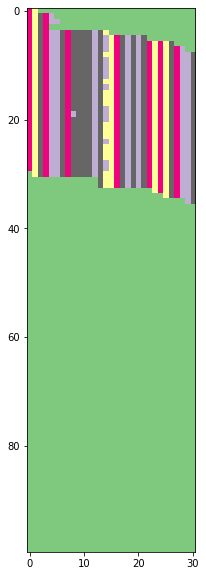

In [ ]:
# let's see the image it created
# channel 1
plt.figure(figsize=(15,10))
plt.imshow(img[:,:,0], cmap='Accent')#  interpolation='none')
plt.show()

From this sample image, looking at the first channel, we can see the aligned reads! In the center (where there is a checkerboard stripe) is the varaint. Sometimes it is not this easily visible if you dont have the reference though.

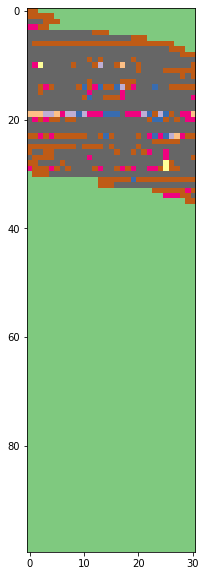

In [ ]:
# now lets look at quality of base reads
# channel 2
plt.figure(figsize=(15,10))
plt.imshow(img[:,:,1], cmap='Accent')#  interpolation='none')
plt.show()

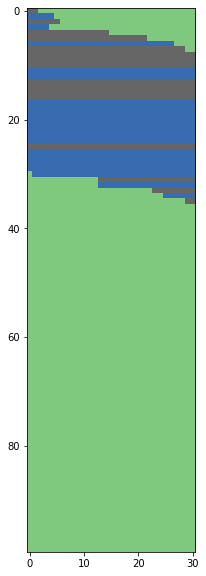

In [ ]:
# now lets look at strand direction
# channel 3
plt.figure(figsize=(15,10))
plt.imshow(img[:,:,2], cmap='Accent')#  interpolation='none')
plt.show()

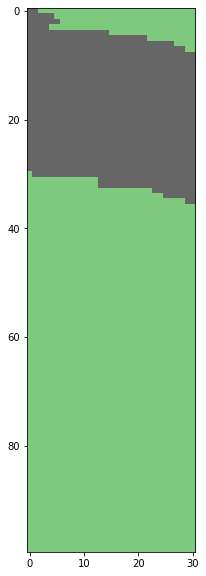

In [ ]:
# now lets look at mapping quality
# channel 4
plt.figure(figsize=(15,10))
plt.imshow(img[:,:,3], cmap='Accent')#  interpolation='none')
plt.show()

# Create Training, Test & Validation sets

I'm choosing to only work with chromosome 1. Pick SNPs in the middle because of soft clip mutations.

Soft-clipped bases should not be used in variant calling. Soft clip bases are bases at the beginning or end of the read that do not align anywhere on the reference.
These bases are likely introduced due to sequencing errors.

In [ ]:
# start at SNP pos: 3317052 arbitrarily picked. 
# to start window around SNP, minus 15 from 3317052 to create the window.

# start loop at position 3317052

# Remove rows from the VCF file that have more than one letter under 'REF', and more than one letter under 'ALT'. 
# For some reason, having multiple ref or alt messes up the image generated. Wasnt able to debug and fix this :(
# subset chromosome 1 data in new dataframe

new_vcf_dataframe = vcf_dataframe.loc[vcf_dataframe['REF'].isin(['G','C','A','T'])]

single_vcf_dataframe = new_vcf_dataframe.loc[new_vcf_dataframe['ALT'].isin(['G','C','A','T'])]

chr1_vcf_dataframe = single_vcf_dataframe.loc[single_vcf_dataframe['CHROM'].isin(['chr1'])]

vcf_positions = chr1_vcf_dataframe['POS'].to_numpy()

In [ ]:
chr1_vcf_dataframe.loc[chr1_vcf_dataframe['POS'].isin(['3627052'])]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NA12878


In [ ]:
# the following is for generating 1,000 images
base_num = np.linspace(3317052, 3348052, num= 1001, dtype=int) # 1,000 images of 31 nucleotides each, need 31,000 nucleotide samples

# the following is for generating 10,000 images
#base_num = np.linspace(3317052, 3627052, num= 10001, dtype=int) # 10,000 images of 31 nucleotides each, need 310,000 nucleotide samples

In [ ]:
# # function to make image and label pairs. center read only.
# def make_list_of_images(bases_list):
#   """
#   Creates a python list of the images that will be used for training/testing.

#   Checks if center read has a variant or not.

#   0 = No variant in image. Ground truth.
#   1 = Variant is in image. Ground truth.
#   """

#   img_variant_list = []
  

#   for pos in range(len(bases_list)-1):
#     reads = get_reads(NA12878_S1_samfile, "chr1", bases_list[pos], bases_list[pos+1])
#     img = generate_image(chrX = 'chr1', position= (bases_list[pos]+16), bamfile = NA12878_S1_samfile, ref = ref, reads = reads)
    
#     yes_list = [bases_list[pos]+16]
#     # if theres an snp here, this is a variant image

#     if any(item in yes_list for item in vcf_positions):
#       img_variant_list.append(np.array(([img],[1]), dtype=object))# YES
#       continue

#     else:
#       img_variant_list.append(np.array(([img],[0]), dtype=object))# NO
#       continue

#   return img_variant_list


In [ ]:
# function to make image and label pairs. looks for any read in the whole image.
def make_list_of_images(bases_list):
  """
  Creates a python list of the images that will be used for training/testing.

  Checks if any read in the image has a variant or not.

  0 = No variant in image. Ground truth.
  1 = Variant is in image. Ground truth.
  """

  img_variant_list = []
  

  for pos in range(len(bases_list)-1):
    reads = get_reads(NA12878_S1_samfile, "chr1", bases_list[pos], bases_list[pos+1])
    img = generate_image(chrX = 'chr1', position= (bases_list[pos]+16), bamfile = NA12878_S1_samfile, ref = ref, reads = reads)
    
    yes_list = list(range(bases_list[pos]+1,bases_list[pos+1]-1)) # dont include first and last read. later will get cut from img for resizing. 
    # if theres an snp here, this is a variant image

    if any(item in yes_list for item in vcf_positions):
      img_variant_list.append(np.array(([img],[1]), dtype=object))# YES
      continue

    else:
      img_variant_list.append(np.array(([img],[0]), dtype=object))# NO
      continue

  return img_variant_list

In [ ]:
img_variant_list = make_list_of_images(base_num)

In [ ]:
## save to google drive!
## 1,000 images
# np.save(f'{DATAOUT}img_variant_list_1000.npy', img_variant_list)
## 10,000 images
# np.save(f'{DATAOUT}img_variant_list_10000.npy', img_variant_list)

<function matplotlib.pyplot.show(close=None, block=None)>

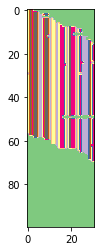

In [ ]:
# see if the function worked
plt.imshow(img_variant_list[999][0][0][:,:,0], cmap='Accent')
plt.show

Since SNPs only occur once every ~1,000 base pairs, we cant just generate images from 30k bases in a row, because then the no variant images will outweigh the variant images. So here I'm generating more variant images for the classifier to train on. I'm pulling the sequence index directly from the VCF file.

In [ ]:
## Enriching the training sample with examples of known SNPs present in the list

# remove low quality reads for this
enriched_df = chr1_vcf_dataframe.loc[chr1_vcf_dataframe['FILTER'] == 'PASS', 'POS'].to_numpy()

## start index for 1,000 sample
start_index = np.where(enriched_df == 3601923) # arbitrarily chose an index thats out of range from the previous sample generator and in the vcf file.

## start index for 10,000 sample
# start_index = np.where(enriched_df == 3620798) # arbitrarily chose an index thats out of range from the previous sample generator and in the vcf file.

only_variants = enriched_df[start_index[0][0]:]

# only_variants_pos = only_variants[:1001] # want 1,000 more samples
only_variants_pos = only_variants[:10001] # want 10,000 more samples


In [ ]:
# This is a supplementary function

def only_variant_images(bases_list, img_variant_list = img_variant_list):
  """
  This function is supplementary to the one in the cell above. It adds to the list created by
  the function above: img_variant_list.
  """
  
  for pos in range(len(bases_list)-1):

    reads = get_reads(NA12878_S1_samfile, "chr1", (bases_list[pos]-16), (bases_list[pos]+15))
    img = generate_image(chrX = 'chr1', position= bases_list[pos], bamfile = NA12878_S1_samfile, ref = ref, reads = reads)
    
    # append to list from before

    img_variant_list.append(np.array(([img],[1]), dtype=object)) # YES


  return img_variant_list

In [ ]:
img_variant_list = only_variant_images(only_variants_pos, img_variant_list)

In [ ]:
## save to google drive!
## save 2,000 list
# np.save(f'{DATAOUT}img_variant_list_2000.npy', img_variant_list)

## save to google drive!
## save 20,000 list
np.save(f'{DATAOUT}img_variant_list_20000.npy', img_variant_list)

Check to see if above code worked.

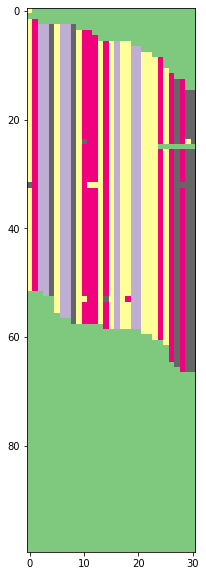

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(img_variant_list[1500][0][0][:,:,0], cmap='Accent') #, interpolation='nearest'
plt.show()

In [ ]:
# only run if need to start from here
# import numpy as np
# img_variant_list = np.load(DATAOUT+'img_variant_list_2000.npy', allow_pickle = True)

In [ ]:
# Train, Val, Test split for 2,000 samples
# 60:20:20 ratio

# train_set = np.concatenate((img_variant_list[:600],img_variant_list[1000:1600]))
# val_set = np.concatenate((img_variant_list[601:800], img_variant_list[1601:1800]))
# test_set = np.concatenate((img_variant_list[801:1000],img_variant_list[1801:2000]))

# train_size, _, _= np.shape(train_set[:])
# val_size, _, _ = np.shape(val_set)
# test_size,_,_ = np.shape(test_set)

In [ ]:
# Train, Val, Test split for 20,000 samples
# 60:20:20 ratio
train_set = np.concatenate((img_variant_list[:6000],img_variant_list[10000:16000]))
val_set = np.concatenate((img_variant_list[6001:8000], img_variant_list[16001:18000]))
test_set = np.concatenate((img_variant_list[8001:10000],img_variant_list[18001:20000]))

train_size, _, _= np.shape(train_set[:])
val_size, _, _ = np.shape(val_set)
test_size,_,_ = np.shape(test_set)

In [ ]:
# separate image and labels for feeding into the model

image_train = train_set[:,0,:]
# turns object to float dtype (originally it is dtype= object):
image_train = np.array(list(image_train[:, 0]), dtype=float)

label_train = train_set[:,1,:]
label_train = np.array(list(label_train[:, 0]), dtype=float)

image_validation = val_set[:,0,:]
image_validation = np.array(list(image_validation[:, 0]), dtype=float)

label_validation = val_set[:,1,:]
label_validation = np.array(list(label_validation[:, 0]), dtype=float)

image_test = test_set[:,0,:]
image_test = np.array(list(image_test[:, 0]), dtype=float)

label_test = test_set[:,1,:]
label_test = np.array(list(label_test[:, 0]), dtype=float)

print('Images: train %d, validation %d, test %d \nLabels: train %d, validation %d, test %d' % \
      (len(image_train), len(image_validation), len(image_test), len(label_train), len(label_validation), len(label_test)))

Images: train 12000, validation 3998, test 3998 
Labels: train 12000, validation 3998, test 3998


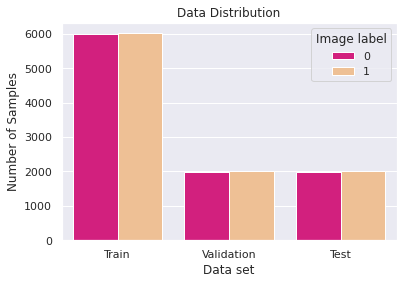

In [ ]:
# plot data split distribution

import seaborn as sns

sns.set()
set_stats = pd.DataFrame({'Data set': ['Train', 'Validation','Test'],
                          '0': [np.count_nonzero(label_train==0), np.count_nonzero(label_validation==0), np.count_nonzero(label_test==0)],
                          '1': [np.count_nonzero(label_train==1), np.count_nonzero(label_validation==1), np.count_nonzero(label_test==1)]})
set_stats_long = set_stats.melt(id_vars='Data set')
set_stats_long.rename(columns = {'value':'Number of Samples', 'variable':'Image label'}, inplace = True)

ax = sns.barplot(data= set_stats_long, x='Data set', y='Number of Samples', hue='Image label', ci=None, palette= "Accent_r")
ax.set_title("Data Distribution")
plt.show()


In [ ]:
# In order to feed the image into the CNN, it must be a number that can be divisible. 
# So one column from the image vector is cropped to achieve size 100x30 which can be passed into a convolution.
# this last column is not crucial for classification anyway.
image_test_crop = image_test[:,:,:30,:]
image_train_crop = image_train[:,:,:30,:]
image_validation_crop = image_validation[:,:,:30,:]

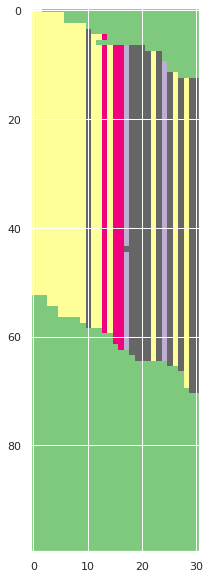

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(image_train[500,:,:,0], cmap='Accent')#  interpolation='none')
plt.show()

# NEURAL NETWORK MODEL





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, random_split
assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

%config Completer.use_jedi = False

Torch version: 1.13.0+cu116


## Dataloader
Reformat the images and labels so that they can be fed into the data loader.

In [ ]:
image_train_torch = torch.from_numpy(image_train_crop).type(torch.FloatTensor).view(-1, 4, 30, 100)
label_train_torch = torch.from_numpy(label_train).type(torch.LongTensor)

image_validation_torch = torch.from_numpy(image_validation_crop).type(torch.FloatTensor).view(-1, 4, 30, 100)
label_validation_torch = torch.from_numpy(label_validation).type(torch.LongTensor)

image_test_torch = torch.from_numpy(image_test_crop).type(torch.FloatTensor).view(-1, 4, 30, 100)
label_test_torch = torch.from_numpy(label_test).type(torch.LongTensor)

train_data = TensorDataset(image_train_torch, label_train_torch)
train_loader = DataLoader(train_data, batch_size = 1, shuffle=True)

val_data = TensorDataset(image_validation_torch, label_validation_torch)
valid_loader = DataLoader(val_data, batch_size = 1, shuffle = True)

test_data = TensorDataset(image_test_torch, label_test_torch)
test_loader = DataLoader(test_data, batch_size = 1)

##CNN Model using PyTorch:

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly used for images. 

[Link](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) to LeNet-5 original model used to classify MNIST dataset.


Here I tried two different versions of the models. Their differences are quite small. Mostly in kernel size, and number of output nodes between layers.

In [ ]:
# This CNN model is similar to the one used to classify MNIST dataset as well as CIFAR10
# modified to fit a 100,30 or 100,30,4 image input.

class LeNetModel(nn.Module):
    '''ConvNet -> ReLU -> Max_Pool -> ConvNet -> ReLU -> Max_Pool -> Reshape -> FC -> Sigmoid -> FC -> Sigmoid -> FC -> SoftMax -> Cross-Entropy
      
      Output H = 
      (input H + (padding Hx2)- kernel H) / (stride)      + 1

      Output W = 
      (output W + (padding Wx2)- kernel W) / (stride)      + 1
    
    '''
    def __init__(self):
        '''Define model modules.'''
        super(LeNetModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, 5, stride =1, padding =0)#in_channels, out_channels, kernel_size, stride=1, padding=0,
        self.conv2 = nn.Conv2d(10, 15, 10, stride=1, padding=1)# in features, out features
        self.fc1 = nn.Linear(15 * 6 * 10, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 15 * 6 * 10)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

model = LeNetModel()
model.cuda()

# Adam optimizer with 0.001 learning rate
optimizer = Adam(model.parameters(), lr = 0.01)
print(model)

LeNetModel(
  (conv1): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 15, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=900, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


This is the one I ended up using for testing:

In [ ]:
class LeNetModel(nn.Module):
    '''ConvNet -> ReLU -> Max_Pool -> ConvNet -> ReLU -> Max_Pool -> Reshape -> Fully Connected -> Sigmoid -> Fully Connected -> Sigmoid -> FC -> SoftMax -> Cross-Entropy

      Output H = 
      (input H + (padding Hx2)- kernel H) / (stride)      + 1

      Output W = 
      (output W + (padding Wx2)- kernel W) / (stride)      + 1

    '''
    def __init__(self):
        '''Define model modules.'''
        super(LeNetModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, 7, stride =1, padding =0)#in_channels, out_channels, kernel_size, stride=1, padding=0,
        self.conv2 = nn.Conv2d(10, 15, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(15 * 23 * 6, 50) # in features, out features
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 15 * 23 * 6)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

model = LeNetModel()
model.cuda()
print(model)

# Adam optimizer with 0.001 learning rate
optimizer = Adam(model.parameters(), lr = 0.001)

LeNetModel(
  (conv1): Conv2d(4, 10, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2070, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


## Train & Validation

In [ ]:
# Train model, 25 epochs
EPOCHS = 25

# Two lists to keep the losses at the end of each epoch.
train_epoch_loss = list()
validation_epoch_loss = list()

for epoch in range(EPOCHS):
    
    # A dummy list to keep the losses at the end of each iteration (one batch forward and backward process).
    train_loss = list()
    valid_loss = list()
    
    #######################################################
    ################### Training Loop #####################
    #######################################################
    
    # Set the model to train mode so that the parameters can be updated.
    model.train()
    
    for batch_index, (train_image, train_label) in enumerate(train_loader):
        train_label_predicted = model(train_image.cuda())

        # compute the loss
        #loss_fun = 
        loss = F.cross_entropy(train_label_predicted, train_label.cuda())
        train_loss.append(loss.cpu().data.item())

        # reset the gradient 
        optimizer.zero_grad()
        # backpropagate the loss
        loss.backward()
        # update the parameters
        optimizer.step()
        
    # Take the average of iteration losses and append it to the epoch losses list
    train_epoch_loss.append(np.mean(train_loss))

            
    #######################################################
    #################### validation #######################
    #######################################################
    
    # Set the model to evaluation mode so that parameters are fixed.
    model.eval()
    
    # Since number of samples in validation is not that large, we can call the model on the whole set at once (No need for looping through samples!)
    # I could not get the model to work without the for loop. This model runs very slow. I wonder if this loop causes the delay.
    for batch_index, (valid_image, valid_label) in enumerate(valid_loader):

        validation_label_predicted = model(valid_image.cuda())
            
        # compare the loss
        loss = F.cross_entropy(validation_label_predicted, valid_label.cuda())
        valid_loss.append(loss.cpu().data.item())
        
    # Take the average of iteration losses and append it to the epoch losses list
    validation_epoch_loss.append(np.mean(valid_loss))
    
    # save models
    torch.save(model.state_dict(),DATAOUT+'/Model_Epochs/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 | train_loss: 0.030464259860197976 | validation_loss: 4.0953427782874385
Epoch: 1 | train_loss: 0.034551334492656675 | validation_loss: 4.653718556551487
Epoch: 2 | train_loss: 0.026277829384178403 | validation_loss: 4.902673999651141
Epoch: 3 | train_loss: 0.024223760530348044 | validation_loss: 5.05619874038501
Epoch: 4 | train_loss: 0.023378639492009825 | validation_loss: 5.172029001209307
Epoch: 5 | train_loss: 0.02294659460154359 | validation_loss: 5.266807366100596
Epoch: 6 | train_loss: 0.022698778600034226 | validation_loss: 5.348043539445586
Epoch: 7 | train_loss: 0.02254789272256509 | validation_loss: 5.419723434314531
Epoch: 8 | train_loss: 0.02245308236580225 | validation_loss: 5.484240350081841
Epoch: 9 | train_loss: 0.022392580449206435 | validation_loss: 5.54313650025216
Epoch: 10 | train_loss: 0.022353901906895242 | validation_loss: 5.5974975168504715
Epoch: 11 | train_loss: 0.022329691051156564 | validation_loss: 5.648114970552088
Epoch: 12 | train_loss: 0.022

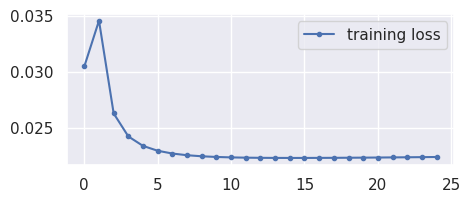

In [ ]:
plt.figure(figsize = (5, 2), dpi = 100)
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
#plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

## Test

In [ ]:
# Predict test set labels

model.eval()
label_predicted_all = []
test_label_true = []
    
for batch_index, (test_image, test_label) in enumerate(test_loader):
    label_predicted_one_hot = model(test_image.cuda())
    label_predicted_probability, label_predicted_index = torch.max(label_predicted_one_hot.data, 1)
    
for current_prediction in label_predicted_index:
    label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

#label_predicted_all

# Accuracy
accuracy = accuracy_score(test_label, label_predicted_all)
print("Accuracy:", accuracy * 100, "%")

Accuracy: 100.0 %


## Evaluation Metrics

In [ ]:
# calculate f1_score
f1score = f1_score(test_label, label_predicted_all)
print("F1 Score:", f1score)

F1 Score: 1.0


In [ ]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(test_label, label_predicted_all)
print("Precision:", precision)
print("Recall:", recall)
print("Thresholds:", thresholds)

Precision: [1. 1.]
Recall: [1. 0.]
Thresholds: [1]


In [ ]:
# confusion matrix